In [1]:
import statistics as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import math
from keras.regularizers import l1, l2
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
import lime
import time
from collections import Counter

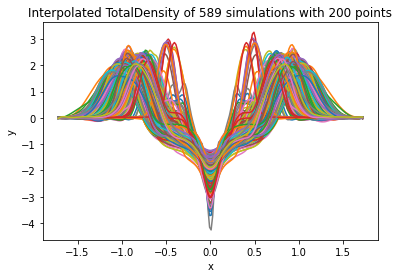

In [5]:
FF_df = pd.read_csv('form_factors.csv')
TD_x_df = pd.read_csv('gpr_total_density_x_200.csv')
TD_y_df = pd.read_csv('gpr_total_density_y_200.csv')

FF_df = FF_df.transpose()
TD_x_df = TD_x_df.transpose()
TD_y_df = TD_y_df.transpose()

for i in range(0,613):
    TD_y_df[i] = TD_y_df[i]-round((TD_y_df[i][0]+TD_y_df[i][199])/2,3)
    
FF_df = (FF_df-FF_df.mean())/FF_df.std()
TD_x_df = (TD_x_df-TD_x_df.mean())/TD_x_df.std()
TD_y_df = (TD_y_df-TD_y_df.mean())/TD_y_df.std()

outlier_column_indexes = set([])

index = 0
for value in TD_y_df.iloc[99]:
    if value > -1:
        outlier_column_indexes.add(index)
    index = index + 1

index = 0 
for value in TD_y_df.iloc[5]:
    if value > 0.30:
        outlier_column_indexes.add(index)
    index = index + 1
    
index = 0 
for value in TD_y_df.iloc[15]:
    if value > 0.30:
        outlier_column_indexes.add(index)
    index = index + 1
    
FF_df = FF_df.drop(outlier_column_indexes, axis=1)
TD_x_df = TD_x_df.drop(outlier_column_indexes, axis=1)
TD_y_df = TD_y_df.drop(outlier_column_indexes, axis=1)

for i in TD_y_df.columns:
    TD_y_df[i] = TD_y_df[i]-round((TD_y_df[i][0]+TD_y_df[i][199])/2,3)
    
i = 0
for index in TD_x_df.columns:
    plt.plot(TD_x_df[index],TD_y_df[index])
    i = i + 1
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('Interpolated TotalDensity of ' + str(i) + ' simulations with 200 points')
plt.show()

In [6]:
input_data = np.array(FF_df.iloc[: , :-14])
output_data_x = np.array(TD_x_df.iloc[: , :-14])
output_data_y = np.array(TD_y_df.iloc[: , :-14])
print(input_data.shape)
print(output_data_x.shape)
print(output_data_y.shape)

random.seed(42)
train = random.sample(range(0,input_data.shape[1]),int(input_data.shape[1]*0.8))
test = []
for number in range(0,input_data.shape[1]):
    if not number in train:
        test.append(number)

print(train)
print(len(train))
print(test)
print(len(test))

train_input_values = []
for number in train:
    train_input_values.append(input_data[:,number])
    
train_output_values = []
for number in train:
    train_output_values.append(np.concatenate((output_data_x[:,number],output_data_y[:,number])))

test_input_values = []
for number in test:
    test_input_values.append(input_data[:,number])
    
test_output_values = []
for number in test:
    test_output_values.append(np.concatenate((output_data_x[:,number],output_data_y[:,number])))
    
train_input_values = np.array(train_input_values).astype(np.float32)
train_output_values = np.array(train_output_values).astype(np.float32)
test_input_values = np.array(test_input_values).astype(np.float32)
test_output_values = np.array(test_output_values).astype(np.float32)

print(train_input_values.shape)
print(train_output_values.shape)
print(test_input_values.shape)
print(test_output_values.shape)

(1000, 575)
(200, 575)
(200, 575)
[114, 25, 281, 250, 228, 142, 104, 558, 89, 432, 32, 30, 95, 223, 238, 517, 27, 203, 429, 225, 459, 284, 6, 163, 565, 348, 553, 159, 220, 344, 568, 94, 389, 99, 367, 352, 270, 44, 470, 127, 387, 80, 300, 370, 196, 71, 46, 233, 296, 81, 560, 103, 542, 548, 464, 373, 166, 379, 363, 214, 273, 73, 175, 571, 83, 236, 194, 138, 506, 473, 327, 539, 285, 112, 350, 518, 431, 393, 397, 28, 117, 420, 16, 412, 161, 205, 137, 33, 108, 467, 482, 290, 448, 540, 490, 486, 335, 255, 202, 452, 468, 329, 234, 513, 135, 529, 126, 381, 287, 275, 134, 382, 299, 219, 554, 298, 204, 185, 501, 70, 260, 252, 528, 386, 24, 440, 56, 78, 321, 525, 405, 549, 216, 305, 564, 197, 195, 441, 239, 538, 128, 283, 5, 443, 369, 58, 349, 274, 384, 136, 497, 328, 174, 57, 150, 222, 533, 232, 1, 430, 368, 520, 256, 390, 91, 259, 54, 320, 152, 504, 409, 311, 101, 447, 191, 411, 82, 276, 271, 0, 306, 165, 511, 9, 421, 457, 157, 122, 29, 123, 483, 40, 43, 374, 248, 35, 272, 64, 65, 337, 243, 572

In [7]:
def single_average_loss(actual,prediction):
    length = int(actual.shape[0]/2)
    
    t_x = actual[0:length]
    t_y = actual[length:]
    p_x = prediction[0:length]
    p_y = prediction[length:]
    
    distance_sum = 0
    for i in range(0,length):
        distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)

    return (distance_sum/length)

def metrics(actual,prediction):
    amount = int(actual.shape[0])
    length = int(actual.shape[1]/2)
    
    index = 0
    loss_list = []
    for data in prediction:
        p_x = data[0:length]
        p_y = data[length:]
        t_x = actual[index][0:length]
        t_y = actual[index][length:]
         
        distance_sum = 0
        for i in range(0,length):
            distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)
            
        loss_list.append(distance_sum/length)
        index = index + 1
     
    average_loss = sum(loss_list)/amount
    mode_loss = Counter(np.round(loss_list,5)).most_common(10)
    median_loss = st.median(np.round(loss_list,5))
    
    plt.hist(np.round(loss_list,5), bins = amount)
    plt.xlabel('Loss')
    plt.ylabel('Amount')
    plt.title('Loss frequency for test data')
    plt.show()
    
    return [average_loss, mode_loss, median_loss]

def plots(actual,prediction):
    random.seed(42)
    train = random.sample(range(0,len(test_input_values)),10)
    for number in train:
        length = int(len(prediction[0])/2)
        x_1 = prediction[number][0:length]
        y_1 = prediction[number][length:]
        plt.plot(x_1,y_1,c='b')

        x_2 = test_output_values[number][0:length]
        y_2 = test_output_values[number][length:]
        plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output curve of the ten random predictions |blue| against actual |red|')
    plt.show() 
    
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b', label='Prediction', alpha=0.25)
        t_x = test_output_values[index][0:length].tolist()
        t_y = test_output_values[index][length:].tolist()
        plt.scatter(t_x,t_y,c='r', label = 'Actual', alpha=0.50)
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction |blue| and actual |red| data')
    plt.show()
    
    number = 10
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))
    
    number = 75
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))
    
    number = 80
    prediction = model.predict(test_input_values)
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show()
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))

In [4]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

NameError: name 'metrics' is not defined

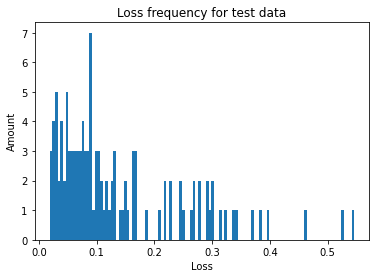

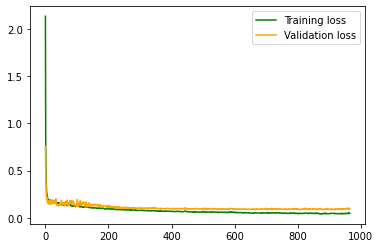

Loss average is: 0.13806331241778033
Loss mode is: [(0.29134, 1), (0.12603, 1), (0.10521, 1), (0.22759, 1), (0.02984, 1), (0.25032, 1), (0.07645, 1), (0.38222, 1), (0.16131, 1), (0.05104, 1)]
Loss median is: 0.09353
Used time: 763.8992307186127 seconds



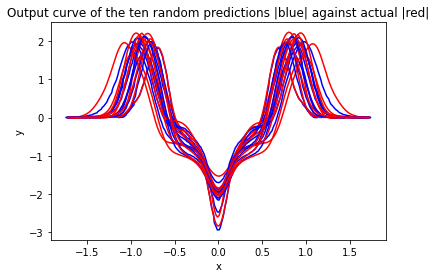

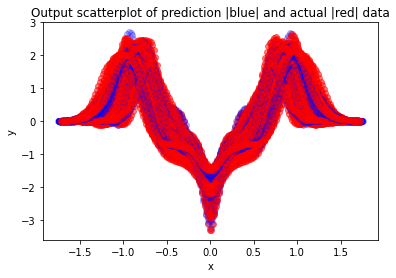

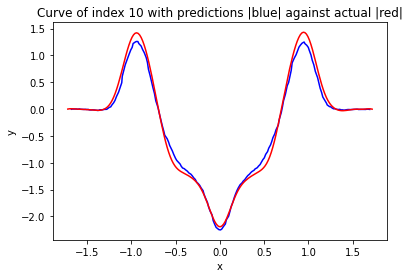

The loss of the curve 0.07955705208445683


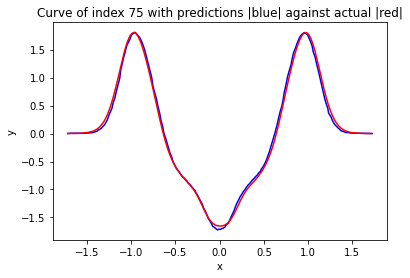

The loss of the curve 0.05256507756100607


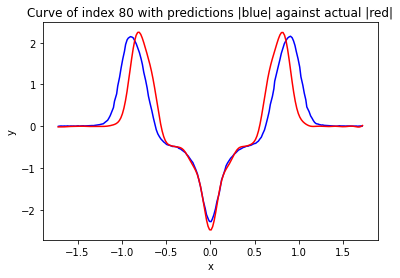

The loss of the curve 0.2766202123381798


In [10]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

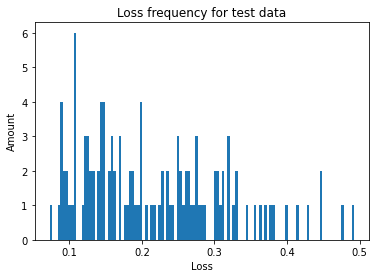

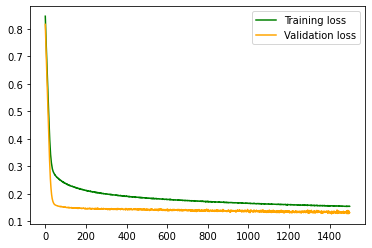

Loss average is: 0.21688062216412138
Loss mode is: [(0.1687, 1), (0.19836, 1), (0.14801, 1), (0.44549, 1), (0.20782, 1), (0.44625, 1), (0.18769, 1), (0.21233, 1), (0.34311, 1), (0.10789, 1)]
Loss median is: 0.19836
Used time: 718.0097184181213 seconds



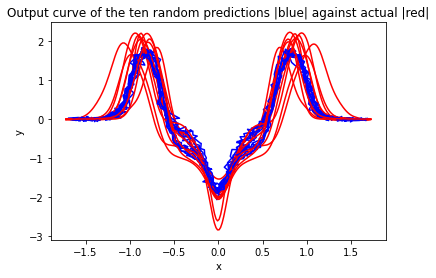

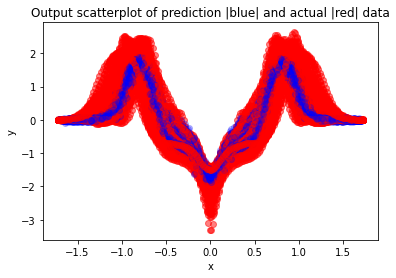

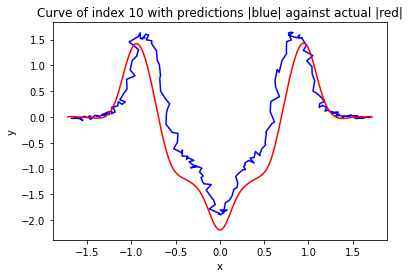

The loss of the curve 0.30292255243718513


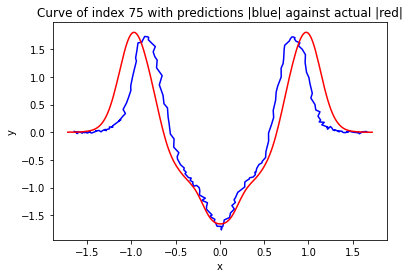

The loss of the curve 0.26116407886605875


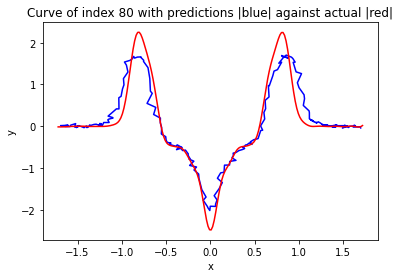

The loss of the curve 0.2630885629314896


In [8]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='SGD', loss='mean_absolute_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

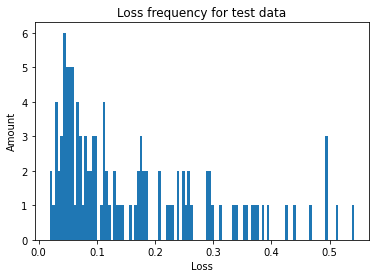

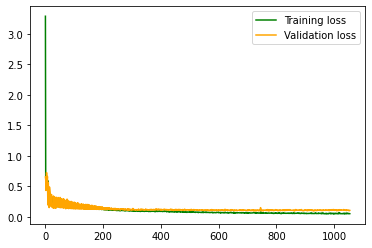

Loss average is: 0.16310079625275942
Loss mode is: [(0.03731, 2), (0.10091, 1), (0.11292, 1), (0.34038, 1), (0.49326, 1), (0.05964, 1), (0.49411, 1), (0.13101, 1), (0.13833, 1), (0.04792, 1)]
Loss median is: 0.11144
Used time: 867.8535854816437 seconds



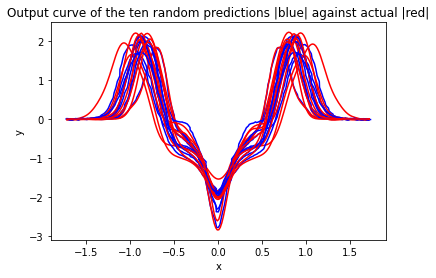

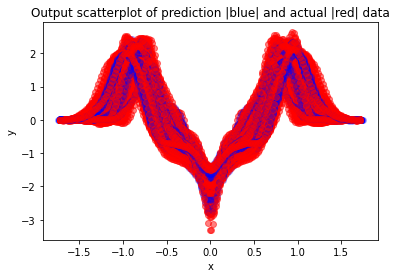

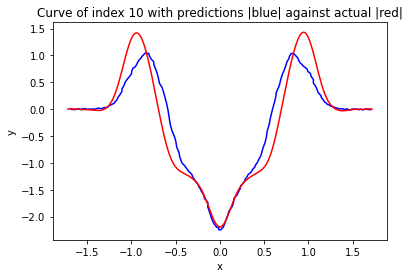

The loss of the curve 0.2066503289444838


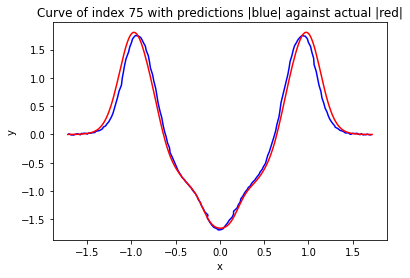

The loss of the curve 0.08084348842262283


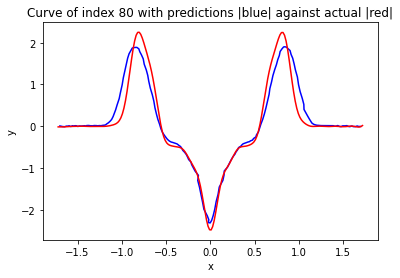

The loss of the curve 0.18683770217745987


In [10]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Nadam', loss='mean_absolute_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

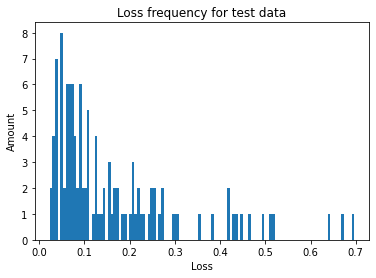

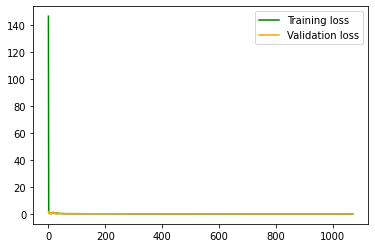

Loss average is: 0.16319997645394899
Loss mode is: [(0.0922, 1), (0.13526, 1), (0.17282, 1), (0.63813, 1), (0.02791, 1), (0.69656, 1), (0.10142, 1), (0.21918, 1), (0.18547, 1), (0.09312, 1)]
Loss median is: 0.10769
Used time: 666.92622590065 seconds



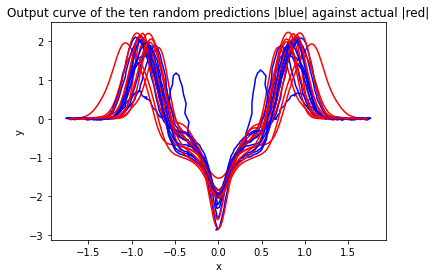

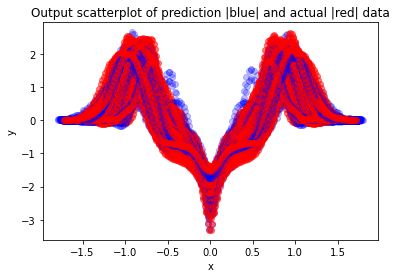

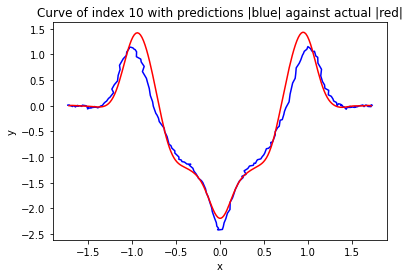

The loss of the curve 0.12852058031586017


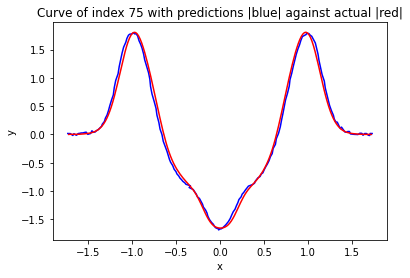

The loss of the curve 0.03231021850809563


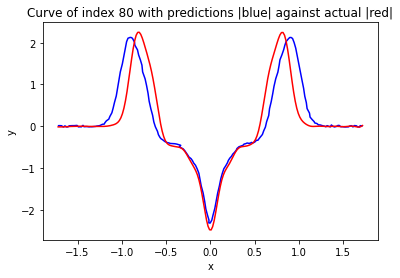

The loss of the curve 0.26331545258365724


In [11]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='RMSprop', loss='mean_absolute_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

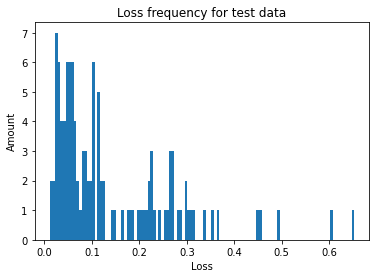

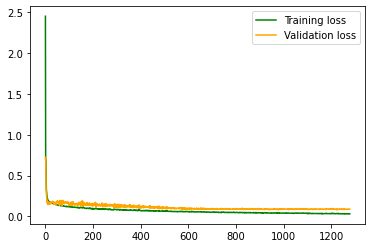

Loss average is: 0.13987427186142656
Loss mode is: [(0.18598, 1), (0.09395, 1), (0.10544, 1), (0.23119, 1), (0.08847, 1), (0.21475, 1), (0.05682, 1), (0.25183, 1), (0.06317, 1), (0.10227, 1)]
Loss median is: 0.09395
Used time: 670.5981652736664 seconds



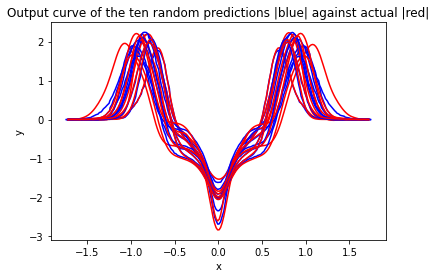

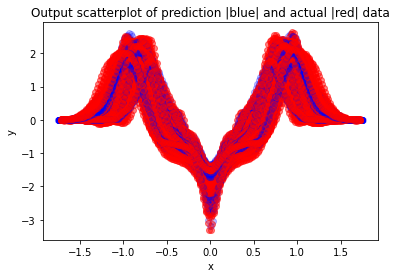

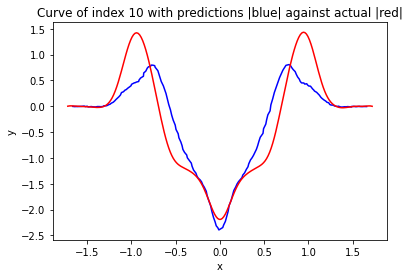

The loss of the curve 0.2884226467289546


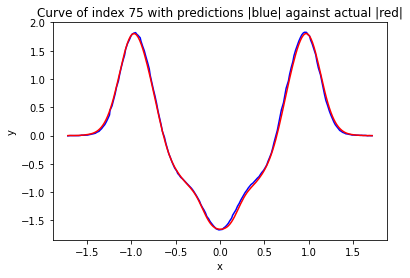

The loss of the curve 0.029454872174830518


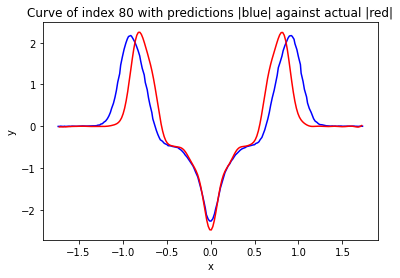

The loss of the curve 0.2965063271018501


In [13]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adamax', loss='mean_absolute_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

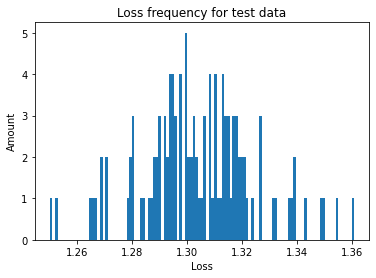

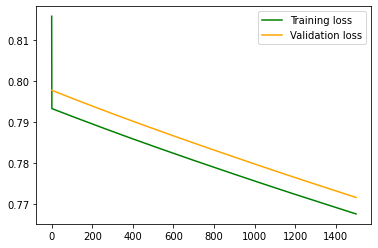

Loss average is: 1.3037705879339485
Loss mode is: [(1.29187, 1), (1.27833, 1), (1.31706, 1), (1.30923, 1), (1.31844, 1), (1.3065, 1), (1.29778, 1), (1.31156, 1), (1.31302, 1), (1.29768, 1)]
Loss median is: 1.30288
Used time: 965.1432719230652 seconds



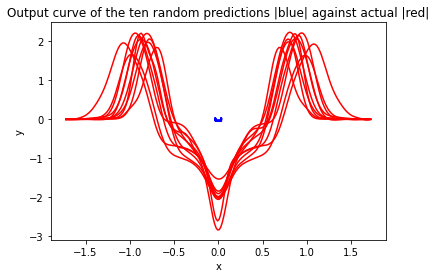

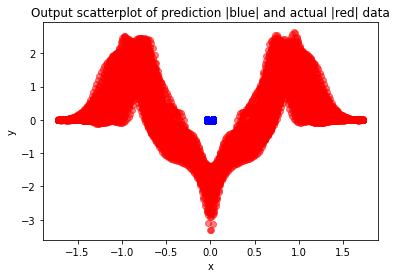

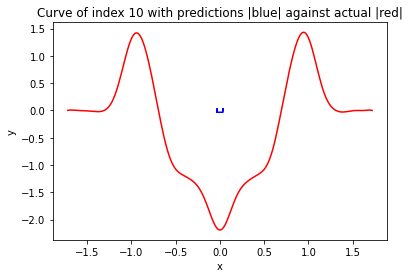

The loss of the curve 1.3606412027972283


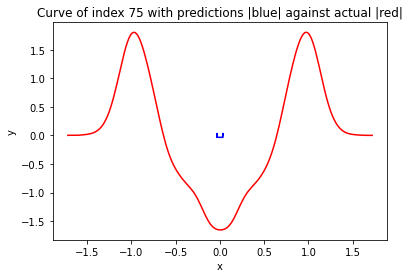

The loss of the curve 1.3195283904050217


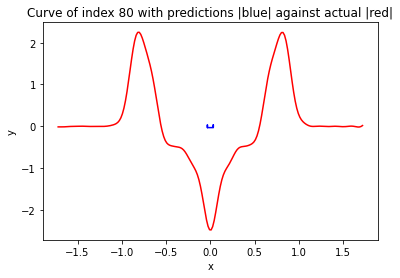

The loss of the curve 1.280340333535779


In [14]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Ftrl', loss='mean_absolute_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

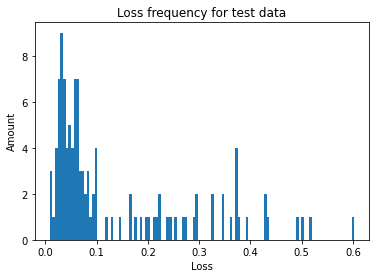

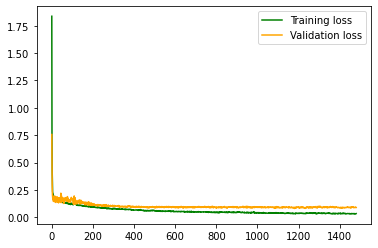

Loss average is: 0.13657859546385231
Loss mode is: [(0.29514, 1), (0.09963, 1), (0.39243, 1), (0.21214, 1), (0.05189, 1), (0.18463, 1), (0.03592, 1), (0.29186, 1), (0.05629, 1), (0.03805, 1)]
Loss median is: 0.06412
Used time: 804.6017441749573 seconds



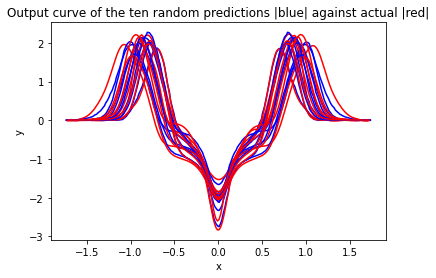

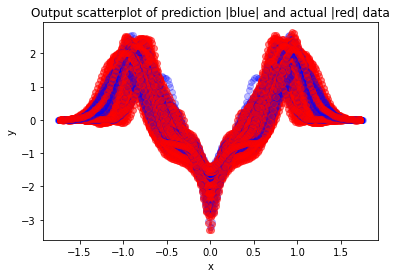

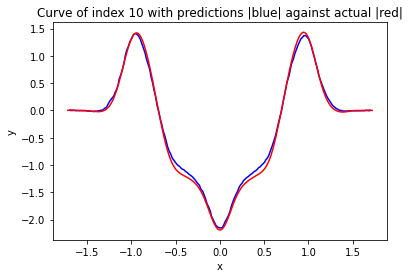

The loss of the curve 0.06340618545415581


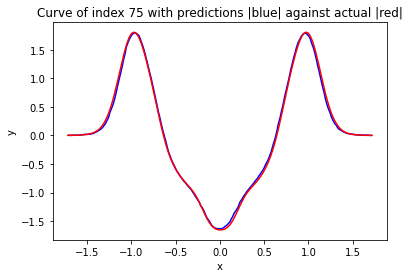

The loss of the curve 0.02007724960719496


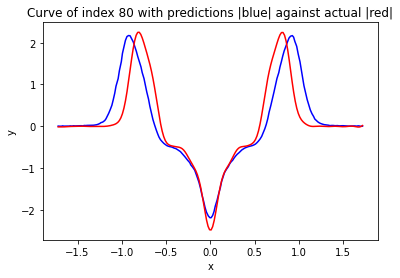

The loss of the curve 0.3260063281603476


In [16]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

Adam = tf.keras.optimizers.Adam(amsgrad=True)

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam, loss='mean_absolute_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

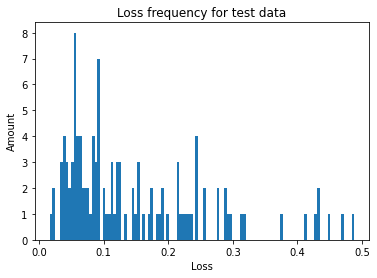

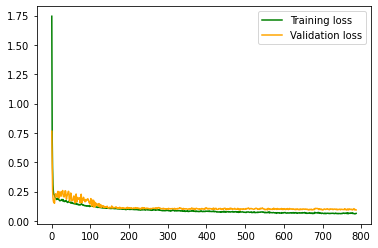

Loss average is: 0.14583122902237713
Loss mode is: [(0.18883, 1), (0.13329, 1), (0.15237, 1), (0.18693, 1), (0.07047, 1), (0.18413, 1), (0.0413, 1), (0.28891, 1), (0.05237, 1), (0.1196, 1)]
Loss median is: 0.10306
Used time: 428.94713139533997 seconds



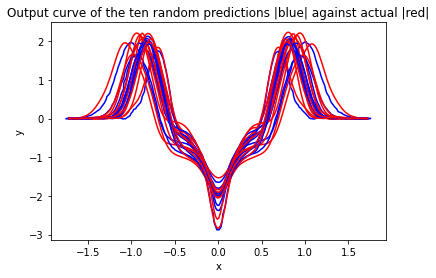

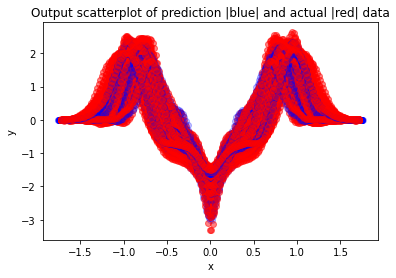

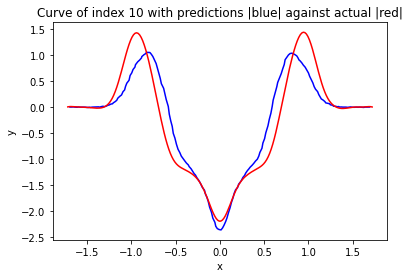

The loss of the curve 0.22951696615298242


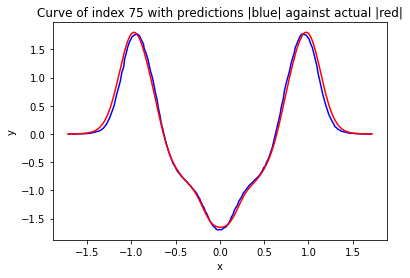

The loss of the curve 0.05459130827222265


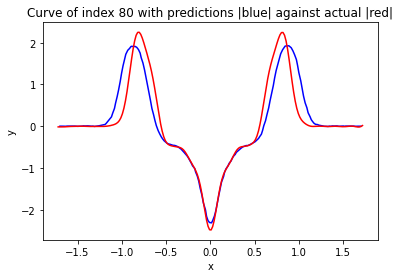

The loss of the curve 0.24234875187217778


In [18]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

Adam = tf.keras.optimizers.Adam(amsgrad=True)

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.2, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.2, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.2, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
x = layers.Dropout(0.2, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam, loss='mean_absolute_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))